<a href="https://colab.research.google.com/github/rinrin528/AIFFEL-1st-Hackathon/blob/main/%EC%8B%9C%EA%B0%81%ED%99%94123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime
import glob, re
import time, datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color = sns.color_palette()

%matplotlib inline



# tra, ar, hr 데이터를 시각화해보자.

In [2]:
data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])        # bring air id to hpg reserve data
data['hs'] = pd.merge(data['hs'], data['id'], how='inner', on=['hpg_store_id'])        # bring air id to hpg stores

In [3]:
data['ar']

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10


In [4]:
print('[--------Data structure--------]')
print('Training data: ',data['tra'].shape)
print('Unique store id in training data: ',len(data['tra']['air_store_id'].unique()))
print('Id data: ',data['id'].shape)
print('Air store data: ',data['as'].shape,'& unique-',data['as']['air_store_id'].unique().shape)
print('Hpg store data: ',data['hs'].shape,'& unique-',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data: ',data['ar'].shape,'& unique-',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data: ',data['hr'].shape,'& unique-',data['hr']['air_store_id'].unique().shape)

[--------Data structure--------]
Training data:  (252108, 3)
Unique store id in training data:  829
Id data:  (150, 2)
Air store data:  (829, 5) & unique- (829,)
Hpg store data:  (63, 6) & unique- (63,)
Air reserve data:  (92378, 4) & unique- (314,)
Hpg reserve data:  (28183, 5) & unique- (150,)


In [5]:
for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_hour'] = data[df]['visit_datetime'].dt.hour
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date


    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_hour'] = data[df]['reserve_datetime'].dt.hour
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date

    data[df+'_hour'] = data[df]#keeping original

    #calculate reserve time difference and summarizing ar,hr to date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    display(data[df])
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    display(data[df])

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_hour,reserve_hour,reserve_datetime_diff
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,19,16,0
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,19,19,0
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,19,19,0
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2,20,16,0
4,air_db80363d35f10926,2016-01-01,2016-01-01,5,20,1,0
...,...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29,2017-04-17,6,18,19,42
92374,air_1033310359ceeac1,2017-05-30,2017-04-19,8,23,17,41
92375,air_877f79706adbfb06,2017-05-31,2017-04-12,3,20,23,49
92376,air_900d755ebd2f7bbd,2017-05-31,2017-04-19,10,20,16,42


,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4
...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,0,2
29826,air_fea5dc9594450608,2017-04-25,9,2
29827,air_fea5dc9594450608,2017-04-28,29,3
29828,air_fea5dc9594450608,2017-05-20,34,6


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id,visit_hour,reserve_hour,reserve_datetime_diff
0,hpg_878cc70b1abc76f7,2016-01-01,2016-01-01,4,air_db80363d35f10926,19,15,0
1,hpg_878cc70b1abc76f7,2016-01-02,2016-01-02,2,air_db80363d35f10926,19,14,0
2,hpg_878cc70b1abc76f7,2016-01-03,2016-01-02,6,air_db80363d35f10926,18,20,1
3,hpg_878cc70b1abc76f7,2016-01-06,2016-01-04,3,air_db80363d35f10926,20,22,2
4,hpg_878cc70b1abc76f7,2016-01-11,2016-01-11,2,air_db80363d35f10926,18,14,0
...,...,...,...,...,...,...,...,...
28178,hpg_0f78ef8d1e4b23d8,2017-04-01,2017-03-10,2,air_84f6876ff7e83ae7,21,20,22
28179,hpg_0f78ef8d1e4b23d8,2017-04-02,2017-04-02,2,air_84f6876ff7e83ae7,17,14,0
28180,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-04-03,3,air_84f6876ff7e83ae7,19,12,5
28181,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-03-09,4,air_84f6876ff7e83ae7,20,7,30


,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5
...,...,...,...,...
18615,air_fea5dc9594450608,2017-04-21,2,2
18616,air_fea5dc9594450608,2017-04-22,0,2
18617,air_fea5dc9594450608,2017-04-25,9,2
18618,air_fea5dc9594450608,2017-04-28,29,3


In [6]:
data['ar']

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4
...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,0,2
29826,air_fea5dc9594450608,2017-04-25,9,2
29827,air_fea5dc9594450608,2017-04-28,29,3
29828,air_fea5dc9594450608,2017-05-20,34,6


In [7]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])    # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek              # 요일 컬럼 생성
data['tra']['year'] = data['tra']['visit_date'].dt.year                  # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month                # month 컬럼 생성
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()

data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)

In [8]:
data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['dow_name'] = data['tes']['visit_date'].dt.day_name()
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month

data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
data['tes']['year_mth'] = data['tes']['year'].astype(str)+'-'+data['tes']['month'].astype(str)

In [9]:
#extract unique stores based on test data and populate dow 1 to 6
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)
stores

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0
...,...,...
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6


In [10]:
# mapping train data dow to stores(test data) - min, mean, median, max, count 
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors' })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0
...,...,...,...,...,...,...,...
5742,air_fea5dc9594450608,6,4.0,11.634146,9.0,35.0,41.0
5743,air_fee8dcf4d619598e,6,11.0,30.200000,31.5,43.0,40.0
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0


In [11]:
# map stores(test) to store genre and location detail
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])

In [12]:
stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229
...,...,...,...,...,...,...,...,...,...,...,...
5742,air_fea5dc9594450608,6,4.0,11.634146,9.0,35.0,41.0,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940
5743,air_fee8dcf4d619598e,6,11.0,30.200000,31.5,43.0,40.0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0,Japanese food,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [13]:
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [14]:
stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,7,82,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,2,102,34.692337,135.472229
...,...,...,...,...,...,...,...,...,...,...,...
5742,air_fea5dc9594450608,6,4.0,11.634146,9.0,35.0,41.0,11,37,34.710895,137.725940
5743,air_fee8dcf4d619598e,6,11.0,30.200000,31.5,43.0,40.0,6,27,34.695124,135.197852
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0,8,25,34.815149,134.685353
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0,7,62,35.658068,139.751599


In [15]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [16]:
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0
...,...,...,...
512,2017-05-27,2,0
513,2017-05-28,3,0
514,2017-05-29,1,0
515,2017-05-30,5,0


In [17]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

display(train)
display(test)

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4,2.0,5.615385,6.0,11.0,39.0,11.0,72.0,35.653217,139.711036
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4,2.0,6.575000,6.0,25.0,40.0,11.0,72.0,35.653217,139.711036
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4,2.0,5.394737,6.0,8.0,38.0,11.0,72.0,35.653217,139.711036
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4,2.0,5.738095,6.0,9.0,42.0,11.0,72.0,35.653217,139.711036


,id,visitors,visit_date,air_store_id,dow,dow_name,year,month,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,Sunday,2017,4,2017-4,2.0,2.000000,2.0,2.0,1.0,6,44,35.694003,139.753595
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,Monday,2017,4,2017-4,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,Tuesday,2017,4,2017-4,1.0,24.350000,24.5,43.0,40.0,6,44,35.694003,139.753595
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,Wednesday,2017,4,2017-4,15.0,28.125000,28.0,52.0,40.0,6,44,35.694003,139.753595
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,Thursday,2017,4,2017-4,15.0,29.868421,30.0,47.0,38.0,6,44,35.694003,139.753595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,2017-05-27,air_fff68b929994bfbd,5,Saturday,2017,5,2017-5,2.0,7.439024,7.0,18.0,41.0,1,65,35.708146,139.666288
32015,air_fff68b929994bfbd_2017-05-28,0,2017-05-28,air_fff68b929994bfbd,6,Sunday,2017,5,2017-5,1.0,4.000000,3.5,10.0,30.0,1,65,35.708146,139.666288
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29,air_fff68b929994bfbd,0,Monday,2017,5,2017-5,1.0,4.200000,4.0,14.0,35.0,1,65,35.708146,139.666288
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30,air_fff68b929994bfbd,1,Tuesday,2017,5,2017-5,1.0,4.526316,4.0,11.0,38.0,1,65,35.708146,139.666288


In [18]:
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

In [19]:
display(train)
display(test)

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4,2.0,5.615385,6.0,11.0,39.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4,2.0,6.575000,6.0,25.0,40.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4,2.0,5.394737,6.0,8.0,38.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4,2.0,5.738095,6.0,9.0,42.0,11.0,72.0,35.653217,139.711036,NaN,NaN,NaN,NaN


,id,visitors,visit_date,air_store_id,dow,dow_name,year,month,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,Sunday,2017,4,2017-4,2.0,2.000000,2.0,2.0,1.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,Monday,2017,4,2017-4,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,Tuesday,2017,4,2017-4,1.0,24.350000,24.5,43.0,40.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,Wednesday,2017,4,2017-4,15.0,28.125000,28.0,52.0,40.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,Thursday,2017,4,2017-4,15.0,29.868421,30.0,47.0,38.0,6,44,35.694003,139.753595,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,2017-05-27,air_fff68b929994bfbd,5,Saturday,2017,5,2017-5,2.0,7.439024,7.0,18.0,41.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN
32015,air_fff68b929994bfbd_2017-05-28,0,2017-05-28,air_fff68b929994bfbd,6,Sunday,2017,5,2017-5,1.0,4.000000,3.5,10.0,30.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29,air_fff68b929994bfbd,0,Monday,2017,5,2017-5,1.0,4.200000,4.0,14.0,35.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30,air_fff68b929994bfbd,1,Tuesday,2017,5,2017-5,1.0,4.526316,4.0,11.0,38.0,1,65,35.708146,139.666288,NaN,NaN,NaN,NaN


In [20]:
train = train.fillna(-1)
test = test.fillna(-1)

In [21]:
print(len(stores.groupby(['latitude','longitude'])['latitude','longitude'].size().reset_index()), 'physical stores')

108 physical stores


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [22]:
import folium
from folium import plugins

location =stores.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Watercolor",# width=1000, height=500,
                        zoom_start = 5)
heatmap=plugins.HeatMap(locationheat).add_to(map1)
map1


In [23]:
data['as']

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [24]:
location =stores.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().reset_index()
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)
marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point],
    icon=folium.Icon(color='white', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


# air_visit_data 시각화
data['tra']

train

In [25]:
data['tra']['visitors'].max()

877

In [26]:
data['tra']

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1
...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4


In [27]:
train

,air_store_id,visit_date,visitors,dow,year,month,dow_name,year_mth,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,Wednesday,2016-1,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,Thursday,2016-1,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,Friday,2016-1,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,Saturday,2016-1,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,Monday,2016-1,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,Tuesday,2017-4,2.0,5.615385,6.0,11.0,39.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,Wednesday,2017-4,2.0,6.575000,6.0,25.0,40.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,Thursday,2017-4,2.0,5.394737,6.0,8.0,38.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,Friday,2017-4,2.0,5.738095,6.0,9.0,42.0,11.0,72.0,35.653217,139.711036,-1.0,-1.0,-1.0,-1.0


In [28]:
data['tra']['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

## (air로 집계한) 월별 방문자 수

Text(0.5, 1.0, 'Visitors')

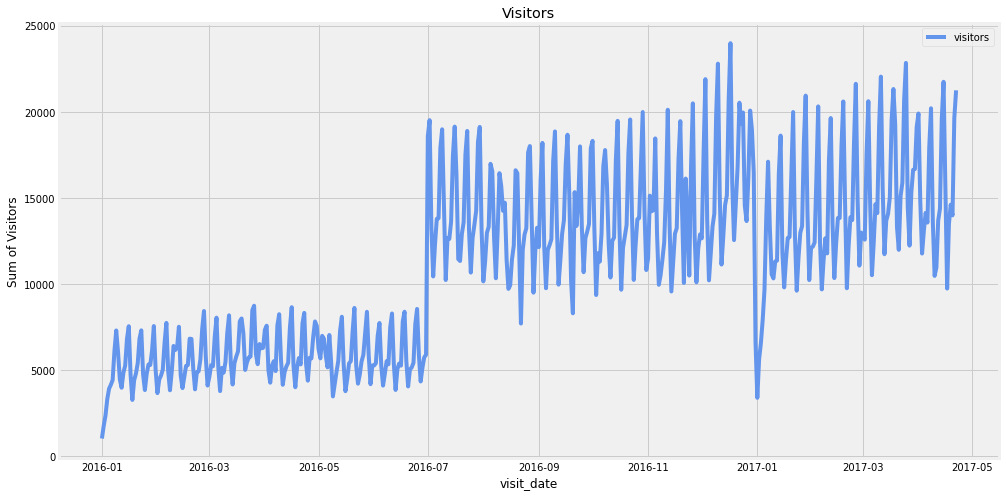

In [29]:
#Visitor each day
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['tra'].groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitors")

## 요일별 평균 방문자 수

In [30]:
df = data['tra'].groupby('dow_name').mean().drop(['year', 'month', 'dow'], axis=1)
df

,visitors
dow_name,
Friday,23.072737
Monday,17.177009
Saturday,26.313688
Sunday,23.873362
Thursday,18.922702
Tuesday,17.672137
Wednesday,19.230121


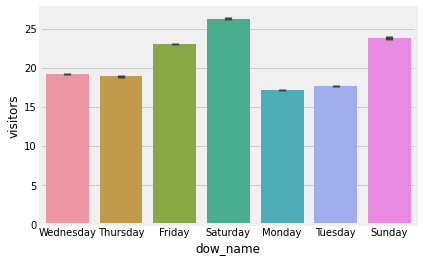

In [32]:
fig = plt.figure()

sns.barplot(x='dow_name', y='visitors', data=data['tra'])

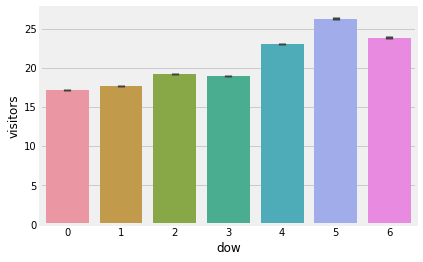

In [33]:
fig = plt.figure()

sns.barplot(x='dow', y='visitors', data=data['tra'])

## 방문자 수 빈도 

[[Python] Python에서 R ggplot2 함수로 그래프 그리기 (by PlotNine library)](https://rfriend.tistory.com/420)

In [34]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes('visitors')) +\
  geom_vline(xintercept = 20, color = 'orange') +\
  geom_histogram(fill = 'blue', bins = 30) +\
  scale_x_log10()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
data['tra'].groupby('month').mean()

[Seaborn으로 히트맵 그리기](https://dsbook.tistory.com/51)

[Pandas - pivot_table, Seaborn](https://essim92.tistory.com/48)

In [ ]:
data['ar_hour']

In [ ]:
train

In [ ]:
data['ar_hour']

In [ ]:
df = pd.merge(train, data['ar_hour'], how='left', on=['air_store_id'])

In [ ]:
df = pd.pivot_table(df, index='year_mth', columns='month', values='visitors')
df

In [ ]:
data['ar']

In [ ]:
sns.heatmap(df)

In [ ]:
sns.histplot(x=data['tra']['dow'], y=data['tra']['visitors'])
sns.set(rc = {'figure.figsize':(15,10)})

In [ ]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes(x='visit_date', y='visitors', group='month', color='month')) \
    + geom_line() \
    + ggtitle('Time Series Graph of Visitors') \
    + labs(y = 'Visitors', x = 'Date')